<a href="https://colab.research.google.com/github/arjasc5231/moodots/blob/ACRNN/SER/CNN/ADRNN/ADRNN_ver3_BN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Speech Emotion Recognition From 3D Log-Mel Spectrograms With Deep Learning network를 바탕으로 구현.  

다음 논문의 특징 중  


1.   ACRNN
2.   dilated cnn
3.   batch normalization
4.   leaky relu
5.   residual
6.   center loss
  
1,2,3,4,5만 우선 구현

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import sys
sys.path.append("/content/drive/MyDrive/team_runner/colab/emoDB/CNN")
from kfold import kfold

In [ ]:
X_train, X_test, Y_train, Y_test = np.load("/content/drive/MyDrive/team_runner/colab/dataset/emoDB/emo_mel_3d.npy", allow_pickle=True)
X = np.concatenate((X_train, X_test), axis=0)
Y = np.concatenate((Y_train, Y_test), axis=0)

print(X.shape)
print(Y.shape)

(911, 128, 128, 3)
(911,)


In [ ]:
def create_model():
    inputs = keras.Input(shape=(128, 128, 3))
    conv1 = keras.layers.Conv2D(filters=64, kernel_size=[3, 3], padding='same', activation=tf.nn.leaky_relu)(inputs)
    pool1 = keras.layers.MaxPool2D()(conv1)
    
    conv2 = keras.layers.Conv2D(filters=128, kernel_size=[3, 3], dilation_rate=2, padding='same')(pool1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.LeakyReLU()(conv2)
    conv3 = keras.layers.Conv2D(filters=128, kernel_size=[3, 3], dilation_rate=2, padding='same')(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.LeakyReLU()(conv3)
    conv4 = keras.layers.Conv2D(filters=128, kernel_size=[3, 3], dilation_rate=2, padding='same')(conv3)
    conv4 = keras.layers.BatchNormalization()(conv4)
    conv4 = keras.layers.LeakyReLU()(conv4)

    conv_res = keras.layers.Conv2D(filters=128, kernel_size=[3, 3], dilation_rate=2, padding='same')(pool1)
    res = keras.layers.Add()([conv_res,conv4])
    res = keras.layers.LeakyReLU()(res)

    trans = keras.layers.Permute((2,1,3))(res)
    reshape = keras.layers.Reshape((-1, 64*128))(trans) # 열 개수(freq축)*ch
    linear = keras.layers.Dense(512)(reshape)
    """
    lstm = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=False, dropout=0.5))(linear)

    fc = keras.layers.Dense(128)(lstm)
    """
    lstm = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.5))(linear) # (time=15,hidden=256)

    attention_score1 = keras.layers.Dense(1, activation='tanh')(lstm) # lstm(time,hidden)*W(hidden,1)=score(time,1)
    attention_score2 = keras.layers.Softmax()(attention_score1)
    attention = keras.layers.Dot(axes=(1,1))([lstm, attention_score2]) # (time=15, hidden=256) * (time,) => (hidden=256)
    flatten = keras.layers.Flatten()(attention)
  
    fc = keras.layers.Dense(128, activation=tf.nn.leaky_relu)(flatten) # 지금껏 activation func을 이 layer에 쓰지 않고있었다는 걸 깨달았다.
    # 윗 주석은 CRNN, 다음 코드는 ACRNN
    drop = keras.layers.Dropout(0.5)(fc)
    output = keras.layers.Dense(7)(drop)
    return keras.Model(inputs=inputs, outputs=output)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 128)  73856       max_pooling2d[0][0]              
______________________________________________________________________________________________

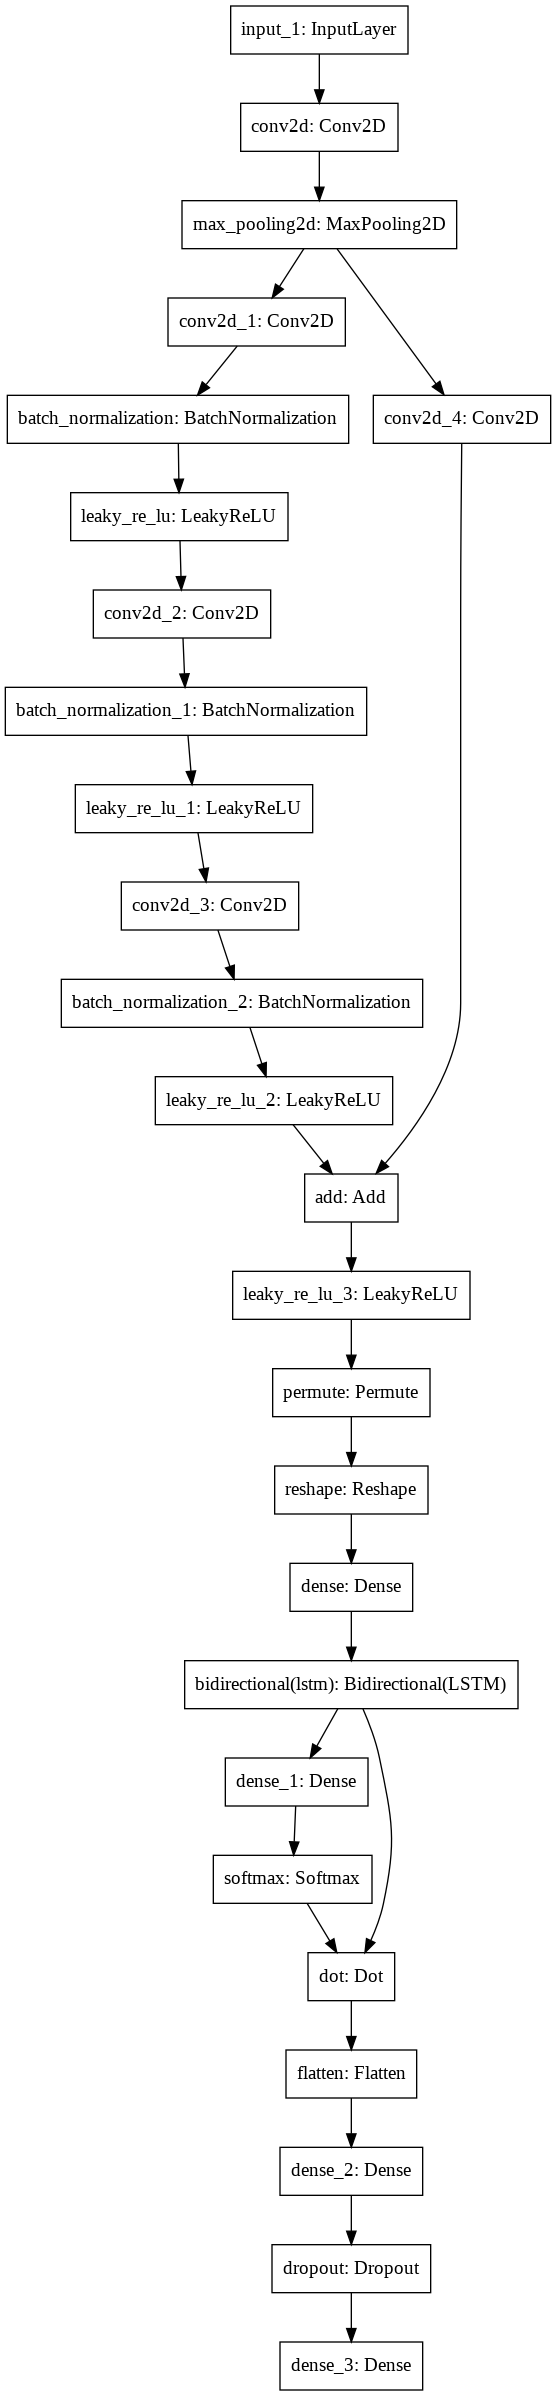

In [ ]:
model = create_model()
model.summary()
keras.utils.plot_model(model)

In [ ]:
kfold(5, create_model, X, Y, 0.001, 100, 200, 10) #0.8516+-0.0303 달성! acc이 진동이 심하고 학습속도가 느림->200epoch. 한 fold에서 80%나온 것이 아쉽다.
# attention안쓰면 학습이 매우 느리다. 75%정도 예상
# 한 fold당 30분

Learning started. k=5
<<fold 1>>
Epoch	loss		train acc	test acc
10  	0.0000  	0.1786  	0.1763
20  	0.0000  	0.4916  	0.4688
30  	0.0000  	0.5693  	0.6192
40  	0.0000  	0.7679  	0.6973
50  	0.0000  	0.9118  	0.7466
60  	0.0000  	0.9275  	0.7685
70  	0.0000  	0.9730  	0.7054
80  	0.0000  	0.9975  	0.7564
90  	0.0000  	0.9862  	0.7714
100  	0.0000  	0.9950  	0.7395
110  	0.0000  	0.9975  	0.7805
120  	0.0000  	0.9925  	0.7735
130  	0.0000  	0.8470  	0.6293
140  	0.0000  	1.0000  	0.7514
150  	0.0000  	0.9950  	0.7614
160  	0.0000  	1.0000  	0.7816
170  	0.0000  	1.0000  	0.8005
180  	0.0000  	1.0000  	0.7875
190  	0.0000  	0.9987  	0.7394
200  	0.0000  	0.9987  	0.7816
max train accuracy: 1.0000
max test accuracy: 0.8326
<<fold 2>>
Epoch	loss		train acc	test acc
10  	0.0000  	0.1566  	0.1260
20  	0.0000  	0.5727  	0.5505
30  	0.0000  	0.4692  	0.4162
40  	0.0000  	0.8028  	0.6848
50  	0.0000  	0.8907  	0.6587
60  	0.0000  	0.9407  	0.7902
70  	0.0000  	0.9750  	0.8113
80  	0.0000  	0.9775